# Imports

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
# from numpy import genfromtxt

# from spectral import envi

import urban_module as ubm

# Functions

In [2]:
def bin_entropy(distarr, c1, c2, num_bins):
    """
    Calculate entropy based on bins and class occurences
    """
    enp = np.zeros(num_bins)
    for i in np.arange(num_bins):
        p1=np.double(distarr[i, c1])
        p2=np.double(distarr[i, c2])
        r1=(p1+1)/(p1+p2+2)
        r2=(p2+1)/(p1+p2+2)
        if (p1+p2!=0):
            enp[i]=-(p1*np.log2(r1)+p2*np.log2(r2))/(p1+p2)
        else:
            enp[i]=1

    return enp

In [3]:
def hist_distribution(tgtband, bandnames, oneimg, clsarr, numcls, num_bins):
    """
    Returns:
    distarr: number of occurences of each class in each bin
    """
    ftidx=bandnames.index(tgtband)
    ftvals=oneimg[ftidx,:]
   
    xlmin=ftvals.min()
    xrmax=ftvals.max()
    pidxlist=[]
    
    distarr = np.zeros((num_bins, numcls),dtype=np.uint64)
    binsize=(xrmax-xlmin)/num_bins
    bounds=np.zeros((num_bins, 2))
   
    for i in np.arange(num_bins):
        bounds[i, 0] = xlmin+i*binsize
        if (i!=num_bins-1):
            bounds[i, 1] = xlmin+(i+1)*binsize
        else:
            bounds[i, 1] = xrmax
    
    for i in np.arange(num_bins):
        if (i!=num_bins-1):
            fbidx=np.where(np.logical_and(ftvals>=bounds[i,0], ftvals<bounds[i,1]))[0]
        else:
            fbidx=np.where(np.logical_and(ftvals>=bounds[i,0], ftvals<=bounds[i,1]))[0]
        
        pidxlist.append(fbidx)
        items = clsarr[fbidx]
        for j in np.arange(numcls):
            distarr[i, j]=np.count_nonzero(items==j)
            
        
       
    return bounds, distarr, pidxlist

In [4]:
def create_training_sets(enp, thd, pidxlist, distarr, clsarr, num_bins, c1, c2):
    c1_train=[]
    c2_train=[]
    binlist=np.where(enp<thd)[0]
    for binidx in binlist:
        fx = pidxlist[binidx]
        if distarr[binidx, c1]>distarr[binidx,c2]:
            c1_idx=fx[clsarr[fx]==c1]
            c1_train.append(c1_idx)
           
        else:
            c2_idx=fx[clsarr[fx]==c2]
            c2_train.append(c2_idx)
           
    
    return c1_train, c2_train

In [5]:
def conclistarr(listarr):
    ntr=len(listarr)
    if ntr>0:
        arr=listarr[0]
        for i in np.arange(1, ntr):
            arr=np.concatenate((arr, listarr[i]), axis=None)
    else:
        arr=np.asarray(listarr)
    
    return arr

In [6]:
def sets_by_sampling(idxset, ds):
    abc=np.random.choice(idxset, 3*ds, replace='False')
    train_set=abc[:ds]
    val_set=abc[ds:2*ds]
    test_set=abc[2*ds:]
    
    return train_set, val_set, test_set

In [7]:
def shuffle_array(ar1):
    ntr=ar1.shape[0]
    shfx=np.random.permutation(ntr)
    ar1=ar1[shfx]
    return ar1

In [8]:
def shuffle_pair(ar1, ar2):
    ntr=ar1.shape[0]
    shfx=np.random.permutation(ntr)
    ar1=ar1[shfx]
    ar2=ar2[shfx]
    return ar1, ar2

In [9]:
def find_feature_index(bandnames, feature_list):
    ntr=len(feature_list)
    flsarr=np.zeros(ntr, dtype=np.int32)
    for i, feature in enumerate(feature_list):
        ftidx=bandnames.index(feature)
        flsarr[i]=ftidx
        
    return flsarr

In [10]:
def create_sets(input_feature_list, wholedata, c1p_index, c1_tra_num, c1_tst_num, c2p_index, c2_tra_num, c2_tst_num, 
                 setname, path):
    """
    Saves out training data
    """
    
    # Output the names of the input features to a text file
    
    feature_arr=np.asarray(input_feature_list)
    filename=path+'/'+setname+'_feature_list'
    np.savetxt(filename, feature_arr,  delimiter=',', fmt='%s')
    
    # prepare the index of training and testing data set
    
    c1p_index=shuffle_array(c1p_index)
    c1_tra_index=c1p_index[:c1_tra_num]
    c1_tst_index=c1p_index[c1_tra_num:c1_tra_num+c1_tst_num]
    
    c2p_index=shuffle_array(c2p_index)
    c2_tra_index=c2p_index[:c2_tra_num]
    c2_tst_index=c2p_index[c2_tra_num:c2_tra_num+c2_tst_num]
    
    #combine class #1 and class #2 pixels to form training and testing set
    
    tra_index=np.concatenate((c1_tra_index, c2_tra_index), axis=None)
    tst_index=np.concatenate((c1_tst_index, c2_tst_index), axis=None)

    # Generate class labels 
    y_train=np.zeros(c1_tra_num+c2_tra_num, dtype=np.float32)
    y_train[c1_tra_num:]=1.0
    y_test=np.zeros(c1_tst_num+c2_tst_num, dtype=np.float32)
    y_test[c1_tst_num:]=1.0
    
    # Form training and tests data sets    
    tra_index, y_train = shuffle_pair(tra_index, y_train)
    tst_index, y_test = shuffle_pair(tst_index, y_test)
    
    x_train = wholedata[tra_index, :]
    x_test =  wholedata[tst_index, :]
    
    # Output training and testing data as binary files 
    filename = setname+'_train_features'
    fileoutput(path, filename , x_train)
 
    filename = setname+'_train_labels'
    fileoutput(path, filename , y_train)
    
    filename = setname+'_test_features'
    fileoutput(path, filename , x_test)
 
    filename = setname+'_test_labels'
    fileoutput(path, filename , y_test)
    

In [11]:
def fileoutput(path, filestem, data):
    """
    Creates a binary file output
    """
    filename=path+'/'+filestem
    data.tofile(filename)

# Main

In [12]:
# Path to unsupervised clustering output
path='/g/data/u46/pjt554/urban_geomedian_data/canberra/2018'

path_out = '/g/data/u46/users/sc0554/LCCS/urban-extents'

### BELOW VARIABLE IS UNUSED ###
# Path to model 
# modeldirc= '/g/data1/u46/pjt554/urban_extent_s2'

# List of features
featurelist=['TSC_BRI', 'MSAVI', 'MNDWI', 'NDVI', 'NDTI', 'DBSI', 'BUI', 'SAVI', 
              'VAUI', 'NDWI','MVAUI', 'WVAUI', 'BSI']#, 'vv_mean','vv_std', 'vv_range','vh_mean', 'vh_std','vh_range']

In [13]:
datastack=[]

sbm=len(featurelist)
print(sbm)

# For each feature load the dataset and append it to a list
for name in featurelist:
    h, oneband, pnum = ubm.load_envi_data_float(path, name)
    #TODO: Assess why this indexing is neccessary
    oneband=oneband[0]
    datastack.append(oneband)
    
print(datastack[0].shape)

13
(2241176,)


In [14]:
# Load the clustering output file
#TODO: This workflow of creating empty arrays to fill with the loaded data could be replaced with a simply numpy load
filename='urban_spec_5c'
h, clsarr, pnum = ubm.load_envi_data_char(path, filename)
clsarr=clsarr[0]
oneimg=np.zeros((sbm, pnum), dtype=np.float32)
for i in np.arange(sbm):
    oneimg[i, :]=datastack[i]

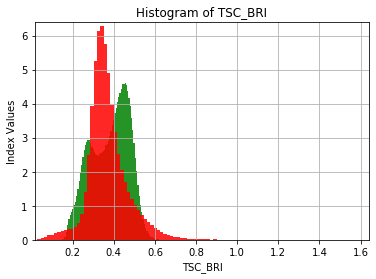

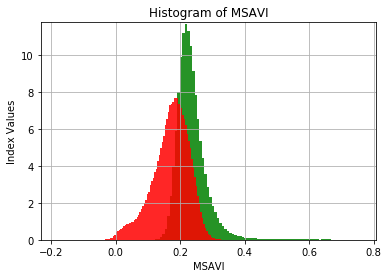

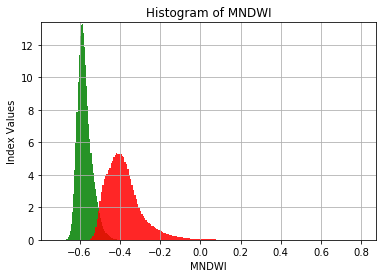

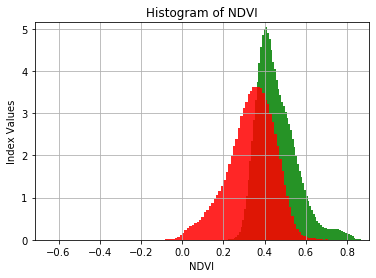

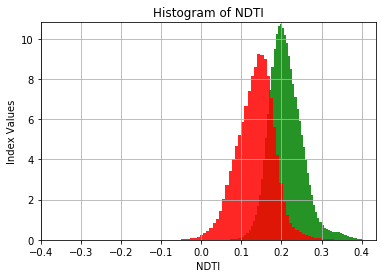

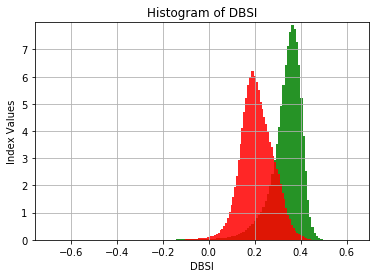

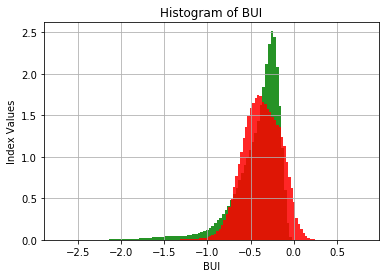

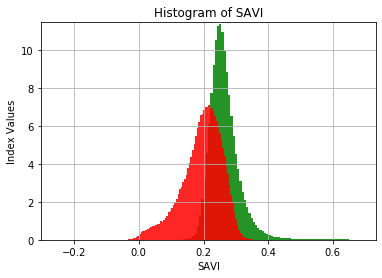

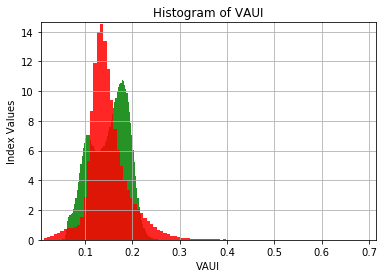

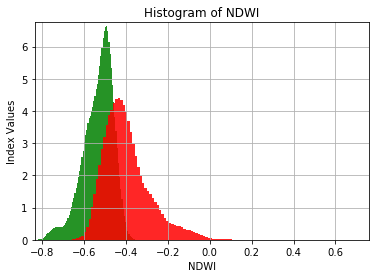

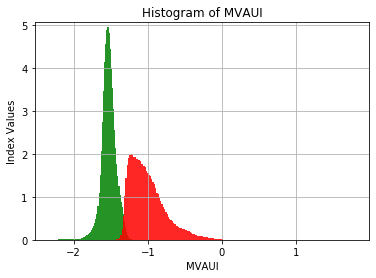

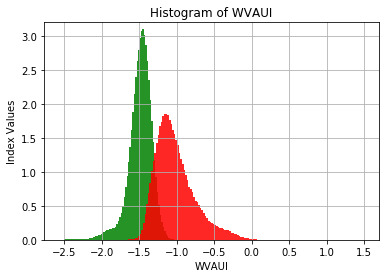

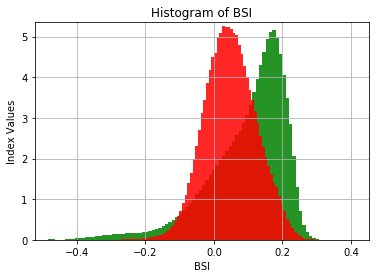

In [15]:
# Plot histograms to check each feature's seperation of vegetation and urban / bare
num_bins=100
for tgtband in featurelist:
    ubm.draw_index_hist(tgtband, featurelist, oneimg, clsarr, num_bins)

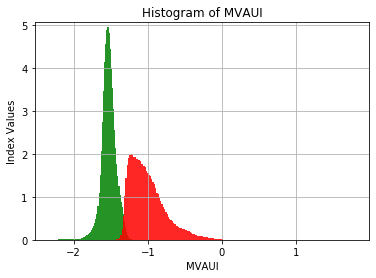

In [16]:
# Plot feature with best seperation
tgtband='MVAUI'
num_bins=100
ubm.draw_index_hist(tgtband, featurelist, oneimg, clsarr, num_bins)

In [17]:
# Number of classes
numcls=4
# distarr is the number of occurences of each class within each bin
bounds, distarr, pidxlist = hist_distribution(tgtband, featurelist, oneimg, clsarr, numcls, num_bins)
# Calculate the entropy for each bin
enp = bin_entropy(distarr, 1, 3, num_bins)

In [18]:
#TODO: What are these variables
# c1 refers to class 1 (green pixels / vegetation)
# c2 refers to class 2 (urban pixels)
# thd refers to threshold
thd=0.03
c1=1
c2=3
c1_train, c2_train = create_training_sets(enp, thd, pidxlist, distarr, clsarr, num_bins, c1, c2)

In [19]:
# Seperate out green and urban pixels
gre_pixels = conclistarr(c1_train)
urb_pixels = conclistarr(c2_train)
ds=min(gre_pixels.shape[0], urb_pixels.shape[0])

In [20]:
# This was enforced as Peter doesn't think that the maximum amount of training data is neccessary for a succesful model
if (ds>50000):
    ds=50000

In [21]:
allbands=['blue', 'green', 'red', 'nir', 'swir1', 'swir2']

bm=len(allbands)
inputdata=np.zeros((pnum, bm), dtype=np.float32)
scale=np.float32(10000.0)

for cc, bandname in enumerate(allbands):
    filename=path+'/NBAR_'+bandname+'.img'
    banddata=np.fromfile(filename, dtype=np.int16)
    # Scale data
    dev=banddata/scale
    inputdata[:, cc]=dev

ValueError: could not broadcast input array from shape (4482352) into shape (2241176)

In [23]:
for cc, bandname in enumerate(allbands):
    print(cc, bandname)

0 blue
1 green
2 red
3 nir
4 swir1
5 swir2


In [30]:
filename

'/g/data/u46/pjt554/urban_geomedian_data/canberra/2018/NBAR_blue.img'

In [ ]:
# Create train and test sets
#TODO: maybe implement this using the SKlearn train and test splitter
c1_tra_num=int(ds*.8)
c1_tst_num=int(ds*.2)
c2_tra_num=c1_tra_num
c2_tst_num=c1_tst_num

In [ ]:
create_sets(featurelist, inputdata, gre_pixels, c1_tra_num, c1_tst_num, urb_pixels, c2_tra_num, c2_tst_num, 
                 'veg_urb', path_out)